In [ ]:
#Importing required libraries
import gc
import h5py
import pickle
import numpy as np
from time import time
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras import layers,Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16,VGG19,MobileNet

In [ ]:
#Function to Load data
def loadDataH5():
    with h5py.File('earth_data.h5','r') as hf:
        trainX = np.array(hf.get('trainX'))
        trainY = np.array(hf.get('trainY'))
        valX = np.array(hf.get('valX'))
        valY = np.array(hf.get('valY'))
        print (trainX.shape,trainY.shape)
        print (valX.shape,valY.shape)
    return trainX, trainY, valX, valY

In [ ]:

#Function to plot the accuracies and losses
def graph(History):
    X = History.epoch
    plt.figure()
    plt.plot(X, History.history["acc"], label="Training Accuracy", color = 'red',linewidth=1.5)
    plt.plot(X, History.history["loss"], label="Training Loss", color = 'green',linewidth=1.5)
    plt.plot(X, History.history["val_acc"], label="Validation Accuracy", color = 'black',linestyle = ":")
    plt.plot(X, History.history["val_loss"], label="Validation Loss", color = 'magenta', linestyle = ":")
    plt.title("Accuracy & Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy | Loss")
    plt.legend()
    plt.grid(False)
    plt.show()

In [ ]:
#Loading data and setting parameters
epochs = 50
batch_size = 512
trainX, trainY, testX, testY = loadDataH5()
trainX, testX = trainX/255, testX/255

(19200, 64, 64, 3) (19200,)
(4800, 64, 64, 3) (4800,)


In [ ]:
#Data Augmentation
IDG = tf.keras.preprocessing.image.ImageDataGenerator(shear_range=0.3, zoom_range=0.3,rotation_range=60, horizontal_flip=True,vertical_flip=True)#, rescale = 1.3, brightness_range=[50,150],channel_shift_range = 1.25,height_shift_range=5,width_shift_range=5)
gen = IDG.flow(trainX, trainY,batch_size = batch_size)



TRAINING MobileNet - CONV Untrainable

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (ReLU

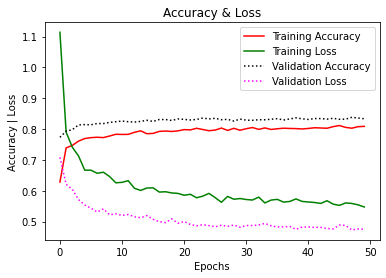

Elapsed time: 762.7140758037567 secs


TRAINING MobileNet - CONV last 3 bunch of layers trainable

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
____________________________

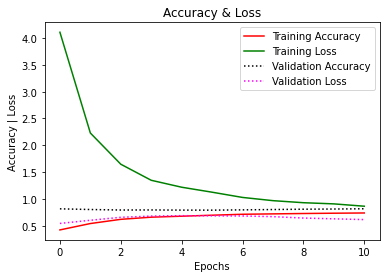

Elapsed time: 170.77203226089478 secs


TRAINING MobileNet - CONV last bunch of layers trainable

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_____________________________

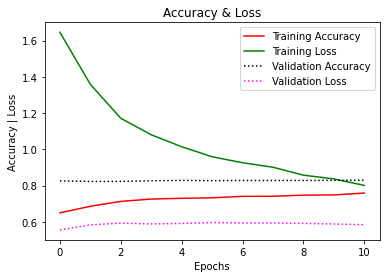

Elapsed time: 168.28174567222595 secs


In [ ]:
# VARIANT 1
results0 = []
print("\n\nTRAINING MobileNet - CONV Untrainable\n")
start = time()
#Mobile Net with 256 FC layer and a softmax layer
MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
x = layers.Flatten()(MobileNet_base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)
MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x)
#Setting Mobilenet as untrainable
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        layer.trainable = False
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_1.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
results0.append(MobileNethist.history)

#Enabling last 3 bunch of layers in mobilenet for training with 1e-5 learning rate
print("\n\nTRAINING MobileNet - CONV last 3 bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["11","12","13"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_2.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
results0.append(MobileNethist.history)

#Enabling only last bunch of layers in mobilenet for training with 1e-5 learning rate - Exploring wrong method wantedly
print("\n\nTRAINING MobileNet - CONV last bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["11","12"]:
            if j in layer.name:
                layer.trainable = False
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_3.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results0.append(MobileNethist.history)



TRAINING MobileNet - CONV Untrainable

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Re

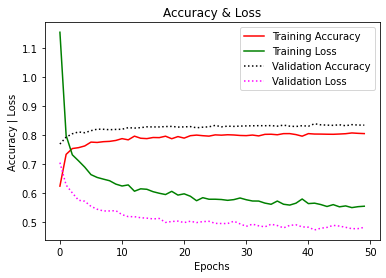

Elapsed time: 776.4196465015411 secs


TRAINING MobileNet - CONV last bunch of layers trainable

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
____________________________

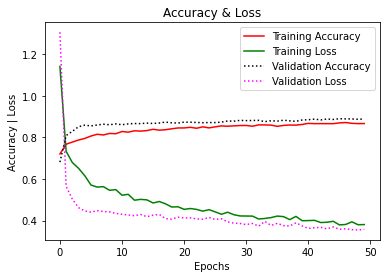

Elapsed time: 760.7188112735748 secs


TRAINING MobileNet - CONV last 3 bunch of layers trainable

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________________________

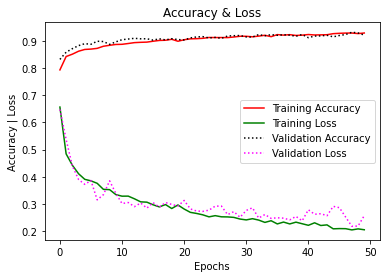

Elapsed time: 764.3555414676666 secs


In [ ]:
#VARIANT 2
results1 = []
#Mobile Net with 256 FC layer and a softmax layer
print("\n\nTRAINING MobileNet - CONV Untrainable\n")
start = time()
MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
x = layers.Flatten()(MobileNet_base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)
MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x)
#Disabling Mobilenet layers for training
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        layer.trainable = False
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_1.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results1.append(MobileNethist.history)

#Enabling only the last bunch of layers of mobilenet for training; LR: 1e-4
print("\n\nTRAINING MobileNet - CONV last bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["13"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_2.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results1.append(MobileNethist.history)

#Enabling the last 3 bunch of layers of mobilenet for training; LR:1e-4
print("\n\nTRAINING MobileNet - CONV last 3 bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["11","12"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_3.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results1.append(MobileNethist.history)



TRAINING MobileNet - CONV Untrainable

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Re

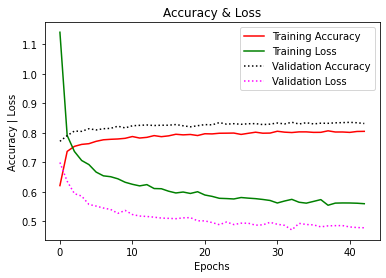

Elapsed time: 651.6168220043182 secs


TRAINING MobileNet - CONV last bunch of layers trainable

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
____________________________

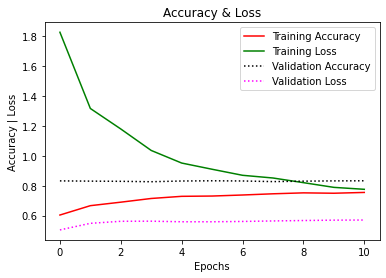

Elapsed time: 168.63023447990417 secs


TRAINING MobileNet - CONV last 3 bunch of layers trainable

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________

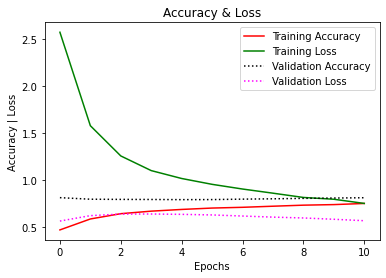

Elapsed time: 167.7595179080963 secs


In [ ]:
# VARIANT 3
results2 = []
#Mobile Net with 256 FC layer and a softmax layer
print("\n\nTRAINING MobileNet - CONV Untrainable\n")
start = time()
MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
x = layers.Flatten()(MobileNet_base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)
MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x)
#Disabling Mobilenet layers for training
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        layer.trainable = False
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_1.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results2.append(MobileNethist.history)

#Enabling only the last bunch of layers of mobilenet for training; LR: 1e-5
print("\n\nTRAINING MobileNet - CONV last bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["13"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_2.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results2.append(MobileNethist.history)

#Enabling the last 3 bunches of layers of mobilenet for training; LR: 1e-5
print("\n\nTRAINING MobileNet - CONV last 3 bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["11","12"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_3.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results2.append(MobileNethist.history)
#     return MobileNet_model



TRAINING MobileNet - CONV Untrainable

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (Re

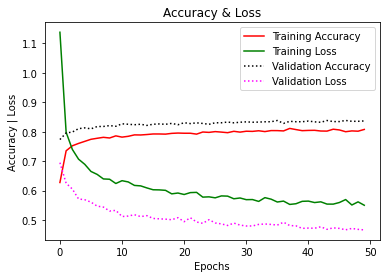

Elapsed time: 767.6375131607056 secs


TRAINING MobileNet - CONV last bunch of layers trainable

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
____________________________

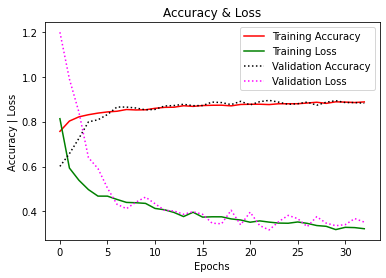

Elapsed time: 502.2117829322815 secs


TRAINING MobileNet - CONV last 3 bunch of layers trainable

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
__________________________

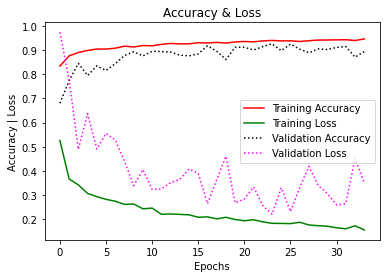

Elapsed time: 519.8266372680664 secs


In [ ]:
# VARIANT 4
#Mobile Net with 256 FC layer and a softmax layer
results3 = []
print("\n\nTRAINING MobileNet - CONV Untrainable\n")
start = time()
MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
x = layers.Flatten()(MobileNet_base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)
MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x)
#Disabling Mobilenet layers for training
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        layer.trainable = False
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_1.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results3.append(MobileNethist.history)

#Enabling the last 3 bunches of layers of mobilenet for training; LR: 1e-3
print("\n\nTRAINING MobileNet - CONV last bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["13"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_2.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results3.append(MobileNethist.history)

#Enabling only the last bunch of layers of mobilenet for training; LR: 1e-3
print("\n\nTRAINING MobileNet - CONV last 3 bunch of layers trainable\n")
start = time()
for i,layer in enumerate(MobileNet_model.layers):
    if "conv" in layer.name:
        for j in ["11","12"]:
            if j in layer.name:
                layer.trainable = True
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_3.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results3.append(MobileNethist.history)



TRAINING MobileNet - CONV All trainable

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 32, 32, 32)        128       
_________________________________________________________________
conv_dw_1_relu (

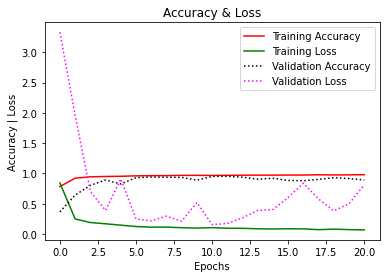

Elapsed time: 346.5735275745392 secs


In [ ]:
# VARIANT 5
#Mobile Net with 256 FC layer and a softmax layer
results4 = []
#All layers are enabled for training
print("\n\nTRAINING MobileNet - CONV All trainable\n")
start = time()
MobileNet_base_model = MobileNet(input_shape = trainX.shape[1:],include_top = False,weights = 'imagenet')
x = layers.Flatten()(MobileNet_base_model.output)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(np.unique(trainY).shape[0], activation='softmax')(x)
MobileNet_model = tf.keras.models.Model(MobileNet_base_model.input, x)
MobileNet_model.compile(optimizer = tf.keras.optimizers.Adam(), loss = 'sparse_categorical_crossentropy',metrics = ['acc'])
checkpoint = ModelCheckpoint("MobileNet_chkpt_TL_1.hdf5", monitor="val_loss", mode="min", save_best_only=True, verbose=1)
early_stopping = EarlyStopping(patience = 10,restore_best_weights=True)
print(MobileNet_model.summary())
MobileNethist = MobileNet_model.fit(gen, batch_size = batch_size, validation_data = (testX, testY), epochs = epochs, steps_per_epoch=trainX.shape[0]/batch_size, callbacks=[checkpoint, early_stopping])
graph(MobileNethist)
print("Elapsed time:",time()-start,"secs")
results4.append(MobileNethist.history)